# Question 1: Data Exploration

**Thomson Reuters Data Science Challenge**

This notebook explores the judicial opinions dataset, reporting:
- Number of documents
- Number of procedural postures (labels)
- Number of paragraphs
- Data characteristics relevant to modeling

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Verify paths
DATA_PATH = project_root / 'data' / 'TRDataChallenge2023.txt'
print(f"Project root: {project_root}")
print(f"Data file exists: {DATA_PATH.exists()}")
print(f"Data file size: {DATA_PATH.stat().st_size / 1e6:.1f} MB" if DATA_PATH.exists() else "File not found")

Project root: /Users/alessandrodibari/Ale/projects/TR_hiring_exercise
Data file exists: True
Data file size: 336.6 MB


In [2]:
from src.data_loader import DataLoader
from src.data_analyzer import DatasetAnalyzer
from src.visualization import (
    plot_posture_distribution,
    plot_text_length_distribution,
    plot_class_imbalance
)

## 1. Load and Inspect Data Schema

In [3]:
# Initialize loader and load data
loader = DataLoader(DATA_PATH)
df = loader.load()

print(f"Loaded {len(df):,} documents")
print(f"\nData Schema:")
for col, dtype in loader.get_schema().items():
    print(f"  {col}: {dtype}")

Loaded 18,000 documents

Data Schema:
  documentId: object
  postures: object
  sections: object


In [4]:
# Preview first few records
print(f"Columns: {loader.get_column_names()}")
print("\nFirst record:")
df.iloc[0]

Columns: ['documentId', 'postures', 'sections']

First record:


documentId                    Ib4e590e0a55f11e8a5d58a2c8dcb28b5
postures                                            [On Appeal]
sections      [{'headtext': '', 'paragraphs': ['Plaintiff Dw...
Name: 0, dtype: object

## 2. Compute Dataset Statistics

The analyzer streams through the data once to compute all required metrics.

In [5]:
# Compute statistics (streams through entire dataset)
analyzer = DatasetAnalyzer(loader)
stats = analyzer.compute_statistics()

# Display summary
print(stats.summary())

DATASET STATISTICS
Number of documents:     18,000
Number of postures:      224
Total paragraphs:        542,172

Text Statistics:
  Avg paragraphs/doc:    30.12
  Avg words/doc:         2891.67
  Min words:             0
  Max words:             124,134
  Median words:          2062

Top 10 Postures:
  On Appeal                                       9197 ( 51.1%)
  Appellate Review                                4652 ( 25.8%)
  Review of Administrative Decision               2773 ( 15.4%)
  Motion to Dismiss                               1679 (  9.3%)
  Sentencing or Penalty Phase Motion or Objecti   1342 (  7.5%)
  Trial or Guilt Phase Motion or Objection        1097 (  6.1%)
  Motion for Attorney's Fees                       612 (  3.4%)
  Post-Trial Hearing Motion                        512 (  2.8%)
  Motion for Preliminary Injunction                364 (  2.0%)
  Motion to Dismiss for Lack of Subject Matter     343 (  1.9%)


In [6]:
# Let's investigate the 234 postures - is this realistic?
# Extract all unique postures
all_postures = df['postures'].explode().dropna()
unique_postures = all_postures.unique()

print(f"Total posture assignments: {len(all_postures):,}")
print(f"Unique posture labels: {len(unique_postures)}")
print("\n--- ALL UNIQUE POSTURES (sorted alphabetically) ---\n")
for i, p in enumerate(sorted(unique_postures), 1):
    print(f"{i:3}. {p}")

Total posture assignments: 27,659
Unique posture labels: 224

--- ALL UNIQUE POSTURES (sorted alphabetically) ---

  1. Appellate Review
  2. Application for Attorneys' or Professional Fees and Expenses
  3. Application for Bankruptcy Trustee Fees
  4. Application to Employ Attorney or Other Professional
  5. Application to Vacate Arbitration Award
  6. Bail or Custody Motion
  7. Certified Question
  8. Declinatory Exception of Improper Venue
  9. Declinatory Exception of Insufficiency of Service of Process
 10. Declinatory Exception of Lack of Personal Jurisdiction
 11. Declinatory Exception of Lack of Subject Matter Jurisdiction
 12. Declinatory Exception of Lis Pendens
 13. Dilatory Exception of Unauthorized Use of Summary Proceeding
 14. Joinder
 15. Jury Selection Challenge or Motion
 16. Juvenile Delinquency Proceeding
 17. Juvenile Wardship Petition
 18. Motion Authorizing and Approving Payment of Certain Prepetition Obligations
 19. Motion For Turnover
 20. Motion for Abandonm

In [7]:
# Analyze posture distribution more carefully
posture_counts = all_postures.value_counts()

print("=== POSTURE FREQUENCY ANALYSIS ===\n")
print(f"Top 20 most common postures (likely 'real' categories):")
print(posture_counts.head(20).to_string())

print(f"\n\nBottom 20 (rare - possible data quality issues?):")
print(posture_counts.tail(20).to_string())

print(f"\n\n=== DISTRIBUTION SUMMARY ===")
print(f"Postures appearing only ONCE: {(posture_counts == 1).sum()}")
print(f"Postures appearing < 10 times: {(posture_counts < 10).sum()}")
print(f"Postures appearing < 100 times: {(posture_counts < 100).sum()}")
print(f"Postures appearing >= 100 times: {(posture_counts >= 100).sum()}")

=== POSTURE FREQUENCY ANALYSIS ===

Top 20 most common postures (likely 'real' categories):
postures
On Appeal                                                         9197
Appellate Review                                                  4652
Review of Administrative Decision                                 2773
Motion to Dismiss                                                 1679
Sentencing or Penalty Phase Motion or Objection                   1342
Trial or Guilt Phase Motion or Objection                          1097
Motion for Attorney's Fees                                         612
Post-Trial Hearing Motion                                          512
Motion for Preliminary Injunction                                  364
Motion to Dismiss for Lack of Subject Matter Jurisdiction          343
Motion to Compel Arbitration                                       255
Motion for New Trial                                               226
Petition to Terminate Parental Rights          

In [12]:
# Quick summary stats
rare = (posture_counts == 1).sum()
very_rare = (posture_counts < 10).sum()
common = (posture_counts >= 100).sum()

print(f"Rare (=1 occurrence): {rare}")
print(f"Very rare (<10): {very_rare}")  
print(f"Common (>=100): {common}")
print(f"\nTop 10: {list(posture_counts.head(10).index)}")
print(f"\nRarest 10: {list(posture_counts.tail(10).index)}")

Rare (=1 occurrence): 44
Very rare (<10): 140
Common (>=100): 27

Top 10: ['On Appeal', 'Appellate Review', 'Review of Administrative Decision', 'Motion to Dismiss', 'Sentencing or Penalty Phase Motion or Objection', 'Trial or Guilt Phase Motion or Objection', "Motion for Attorney's Fees", 'Post-Trial Hearing Motion', 'Motion for Preliminary Injunction', 'Motion to Dismiss for Lack of Subject Matter Jurisdiction']

Rarest 10: ['Motion to Extend Claims Bar Date', 'Declinatory Exception of Improper Venue', 'Joinder', 'Motion to Vacate Arbitration Award', 'Motion to Appoint Chapter 11 Trustee or Examiner', 'Dilatory Exception of Unauthorized Use of Summary Proceeding', 'Motion for Genetic Testing', 'Motion to Transfer Guardianship', 'Motion for Witness List or Production of Witnesses', 'Motion to Allow Late Filing of Proof of Claim']


### Posture Taxonomy for Modeling Decisions

234 postures is realistic but creates a **severe class imbalance** problem. We organize them into tiers:

In [13]:
# Reload module to get updated classes
import importlib
import src.data_analyzer
importlib.reload(src.data_analyzer)
from src.data_analyzer import DatasetAnalyzer, PostureTaxonomy

# Recreate analyzer with updated class
analyzer = DatasetAnalyzer(loader)
taxonomy = analyzer.get_posture_taxonomy()

# Summary
summary = taxonomy.summary()
print("=== POSTURE TAXONOMY SUMMARY ===\n")
for k, v in summary.items():
    if isinstance(v, float):
        print(f"{k}: {v:.1%}" if 'coverage' in k else f"{k}: {v:.2f}")
    else:
        print(f"{k}: {v}")

print(f"\n\n=== MODELING RECOMMENDATION ===")
viable_50 = taxonomy.get_modeling_subset(50)
print(f"Using min_samples=50 for training: {len(viable_50)} postures")
print(f"Coverage: {taxonomy.all_postures[viable_50].sum() / taxonomy.all_postures.sum():.1%} of all labels")

=== POSTURE TAXONOMY SUMMARY ===

total_unique: 224
common_count: 27
moderate_count: 57
rare_count: 140
singleton_count: 44
total_assignments: 27659
common_coverage: 91.5%


=== MODELING RECOMMENDATION ===
Using min_samples=50 for training: 41 postures
Coverage: 94.8% of all labels


In [14]:
# Save taxonomy to JSON for model development reference
import json

taxonomy_dict = {
    'summary': taxonomy.summary(),
    'tiers': {
        'common': taxonomy.common,  # >= 100 samples
        'moderate': taxonomy.moderate,  # 10-99 samples
        'rare': taxonomy.rare,  # < 10 samples
    },
    'modeling_subset_50': taxonomy.get_modeling_subset(50),
    'full_distribution': taxonomy.all_postures.to_dict()
}

# Save to data directory
output_path = project_root / 'data' / 'posture_taxonomy.json'
with open(output_path, 'w') as f:
    json.dump(taxonomy_dict, f, indent=2)

print(f"✓ Saved taxonomy to {output_path}")
print(f"\nContents:")
print(f"  - {len(taxonomy.common)} common postures (≥100 samples)")
print(f"  - {len(taxonomy.moderate)} moderate postures (10-99 samples)")
print(f"  - {len(taxonomy.rare)} rare postures (<10 samples)")
print(f"  - {len(taxonomy.get_modeling_subset(50))} viable for training (≥50 samples)")

✓ Saved taxonomy to /Users/alessandrodibari/Ale/projects/TR_hiring_exercise/data/posture_taxonomy.json

Contents:
  - 27 common postures (≥100 samples)
  - 57 moderate postures (10-99 samples)
  - 140 rare postures (<10 samples)
  - 41 viable for training (≥50 samples)


### Key Metrics (Question 1 Requirements)

In [15]:
print("="*50)
print("REQUIRED METRICS")
print("="*50)
print(f"Number of documents:   {stats.num_documents:,}")
print(f"Number of postures:    {stats.num_postures}")
print(f"Total paragraphs:      {stats.total_paragraphs:,}")
print("="*50)

REQUIRED METRICS
Number of documents:   18,000
Number of postures:    224
Total paragraphs:      542,172


## 3. Posture (Label) Distribution Analysis

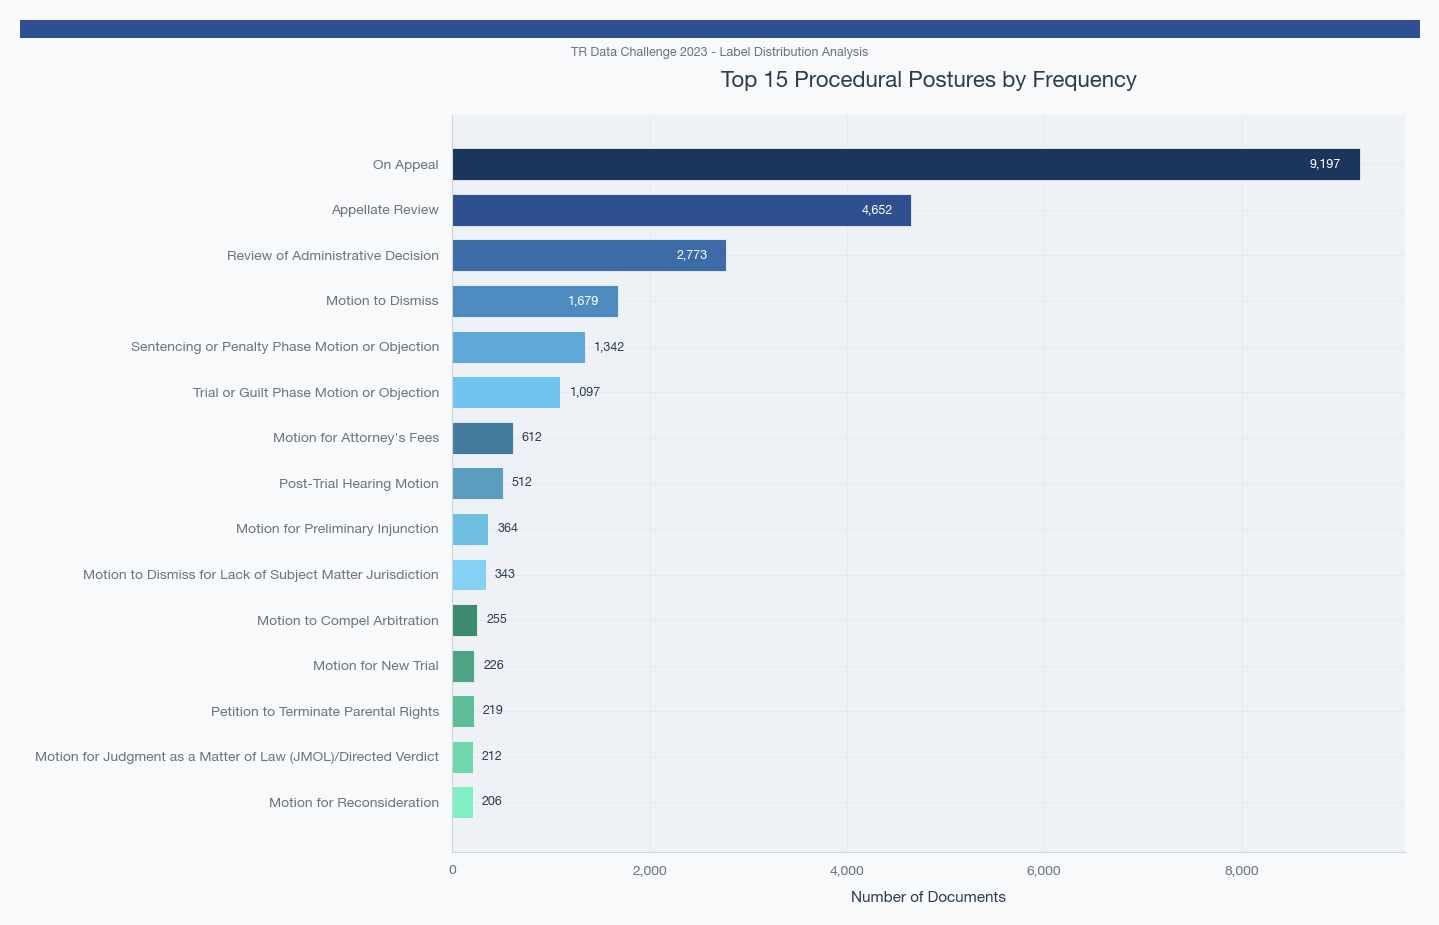

In [21]:
# Visualize top postures
fig = plot_posture_distribution(stats, top_n=15)

# Save figure
output_dir = project_root / 'outputs'
output_dir.mkdir(exist_ok=True)
fig.savefig(output_dir / 'posture_distribution.png', dpi=150, bbox_inches='tight')

Class imbalance ratio (max/min): 9197.0x


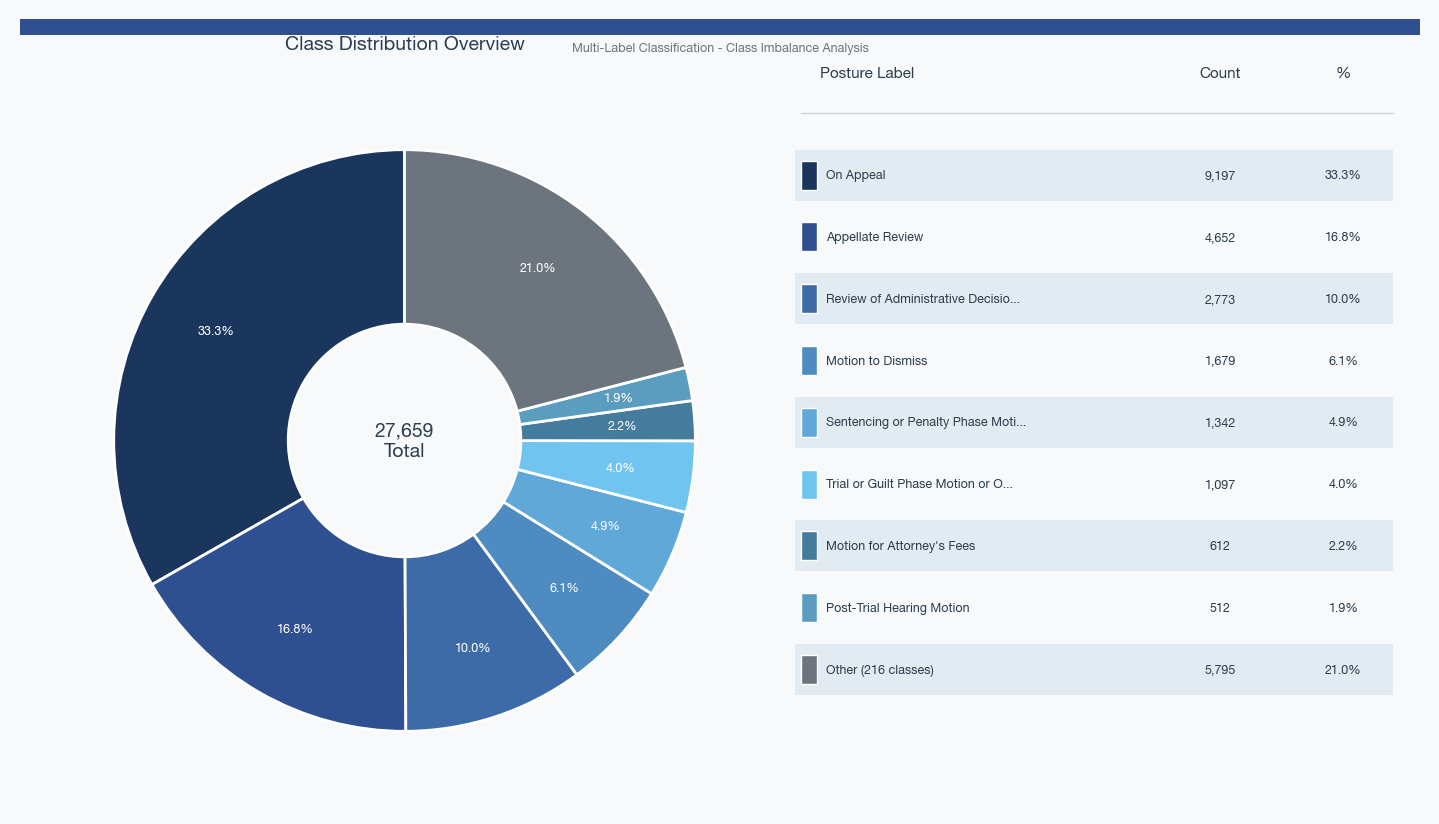

In [24]:
# Class imbalance analysis
imbalance_ratio = analyzer.get_class_imbalance_ratio()
print(f"Class imbalance ratio (max/min): {imbalance_ratio:.1f}x")

# Show class distribution pie chart
fig = plot_class_imbalance(stats)

## 4. Text Characteristics

Understanding text length and structure is important for model selection.

Word count statistics:
  Min:    0
  Max:    124,134
  Mean:   2,892
  Median: 2,062


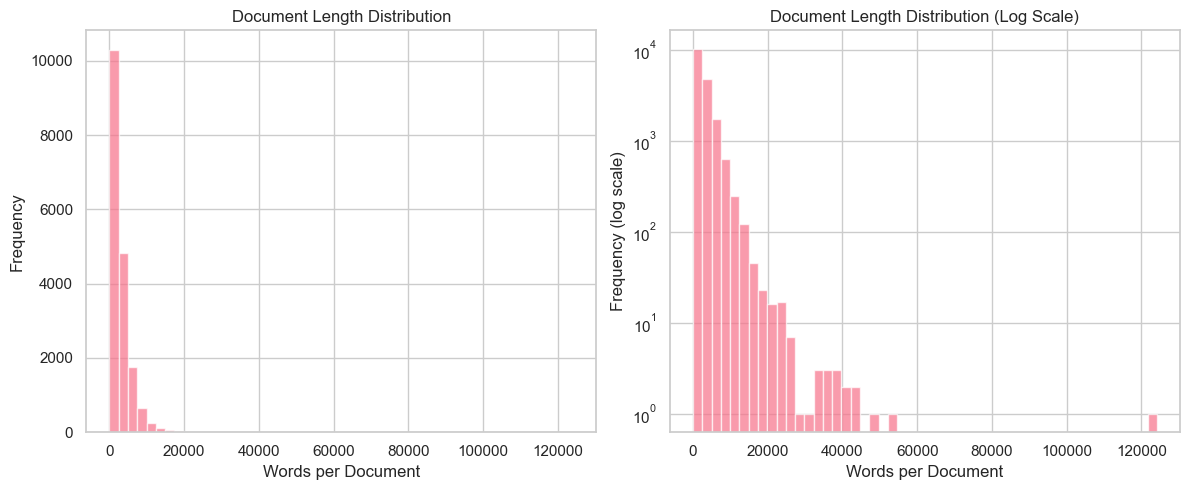

In [18]:
# Get word counts from analyzer
word_counts = analyzer.get_word_counts()

print(f"Word count statistics:")
print(f"  Min:    {word_counts.min():,}")
print(f"  Max:    {word_counts.max():,}")
print(f"  Mean:   {word_counts.mean():,.0f}")
print(f"  Median: {word_counts.median():,.0f}")

# Plot distribution
fig = plot_text_length_distribution(word_counts)

## 5. Observations Relevant to Modeling

Based on the data exploration, here are key observations that will inform the modeling approach in Question 2:

In [19]:
# Generate modeling-relevant observations
imbalance_ratio = analyzer.get_class_imbalance_ratio()

observations = [
    f"1. **Multi-class classification**: {stats.num_postures} distinct posture labels",
    f"2. **Class imbalance**: Ratio of {imbalance_ratio:.1f}x between largest and smallest class",
    f"3. **Document length variability**: {stats.min_words:,} to {stats.max_words:,} words",
    f"4. **Average document length**: {stats.avg_words_per_doc:,.0f} words (may need truncation for transformers)",
    f"5. **Paragraph structure**: {stats.avg_paragraphs_per_doc:.1f} paragraphs per document on average",
]

for obs in observations:
    print(obs)

1. **Multi-class classification**: 224 distinct posture labels
2. **Class imbalance**: Ratio of 9197.0x between largest and smallest class
3. **Document length variability**: 0 to 124,134 words
4. **Average document length**: 2,892 words (may need truncation for transformers)
5. **Paragraph structure**: 30.1 paragraphs per document on average


---

## Summary

This notebook completed the data exploration requirements for Question 1:

1. ✅ Loaded data programmatically using streaming JSON Lines parser
2. ✅ Reported document count, posture count, and paragraph count
3. ✅ Analyzed label distribution and class imbalance
4. ✅ Characterized text properties relevant to modeling

The analysis reveals challenges for the modeling task:
- Significant class imbalance will require stratified sampling or class weighting
- Long documents may need text truncation or chunking strategies
- Many posture classes may benefit from hierarchical or few-shot approaches